In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Paths
data_dir = r'C:\USERS\SUCHI\ONEDRIVE\DESKTOP\AOTOS2019'
train_csv = os.path.join(data_dir, 'train.csv')
test_csv = os.path.join(data_dir, 'test.csv')
train_images_dir = os.path.join(data_dir, 'train_images')

# Load train labels
train_df = pd.read_csv(train_csv)
train_df['diagnosis'] = train_df['diagnosis'].astype(str)  

# Image size and preprocessing
IMG_SIZE = 224
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize
    return img

# Load images and labels
X = []
y = []
for idx, row in train_df.iterrows():
    img_path = os.path.join(train_images_dir, row['id_code'] + '.png')
    X.append(preprocess_image(img_path))
    y.append(row['diagnosis'])

X = np.array(X)
y = to_categorical(np.array(y), num_classes=5)  # Convert labels to one-hot encoding

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pretrained model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(5, activation='softmax')(x)  # 5 classes for diabetic retinopathy

model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('dr_best_model.keras', save_best_only=True, monitor='val_accuracy')
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.9737 - loss: 0.0847 - val_accuracy: 0.7271 - val_loss: 0.9442 - learning_rate: 4.0000e-06
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.9765 - loss: 0.0794 - val_accuracy: 0.7053 - val_loss: 1.1181 - learning_rate: 4.0000e-06
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.9778 - loss: 0.0756 - val_accuracy: 0.7599 - val_loss: 1.0360 - learning_rate: 4.0000e-06
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.9756 - loss: 0.0736 - val_accuracy: 0.8158 - val_loss: 0.8533 - learning_rate: 4.0000e-06
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9756 - loss: 0.0766 - val_accuracy: 0.8117 - val_loss: 0.8484 - learning_rate: 4.0000e-06
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.9788 - loss: 0.0620 - val_accuracy: 0.8199 - val_loss: 0.8435 - learning_rate: 4.0000e-06
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.9800 

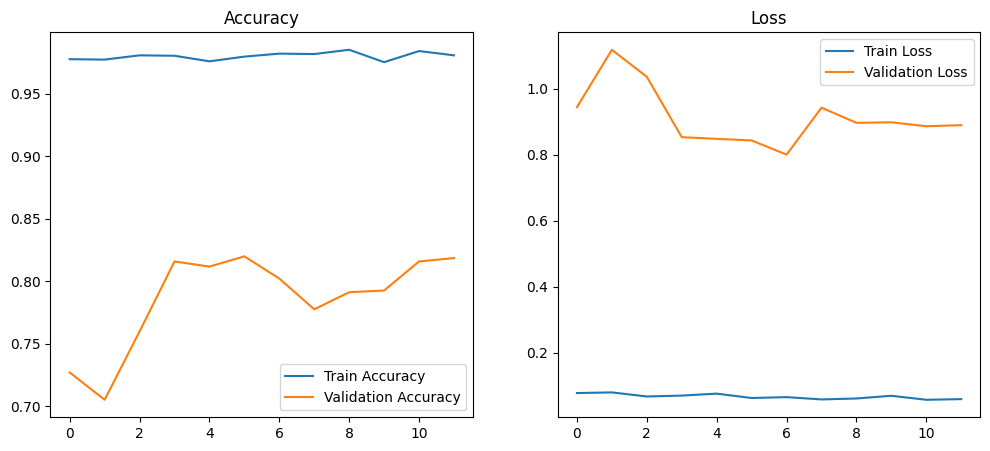

23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 743ms/step


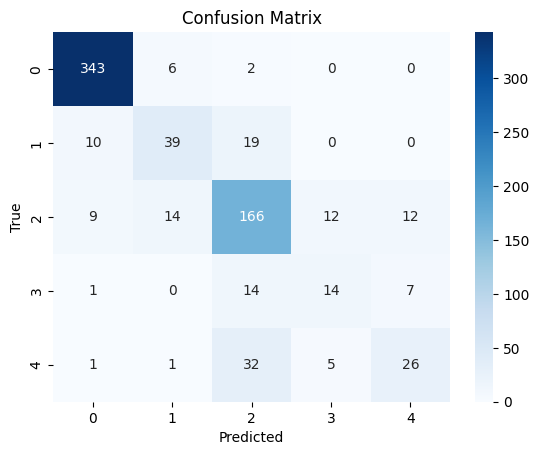

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       351
           1       0.65      0.57      0.61        68
           2       0.71      0.78      0.74       213
           3       0.45      0.39      0.42        36
           4       0.58      0.40      0.47        65

    accuracy                           0.80       733
   macro avg       0.67      0.62      0.64       733
weighted avg       0.79      0.80      0.79       733



In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot accuracy and loss
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_metrics(history)

# Confusion Matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes))


In [6]:

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


Validation Loss: 0.8006102442741394
Validation Accuracy: 0.8021827936172485


In [7]:
model.save('diabetic_retinopathy.keras')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


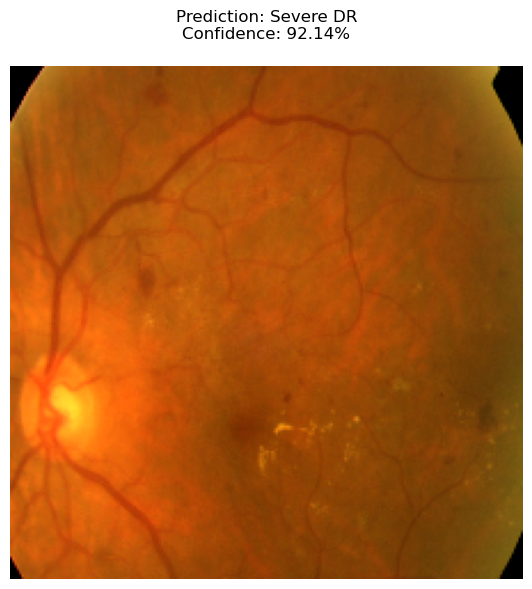

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


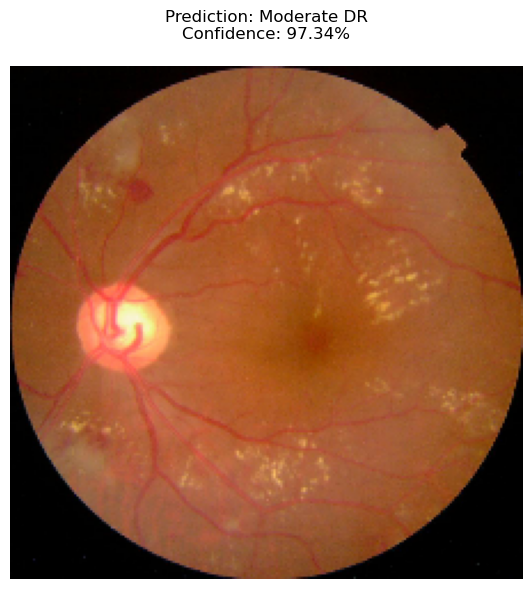

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


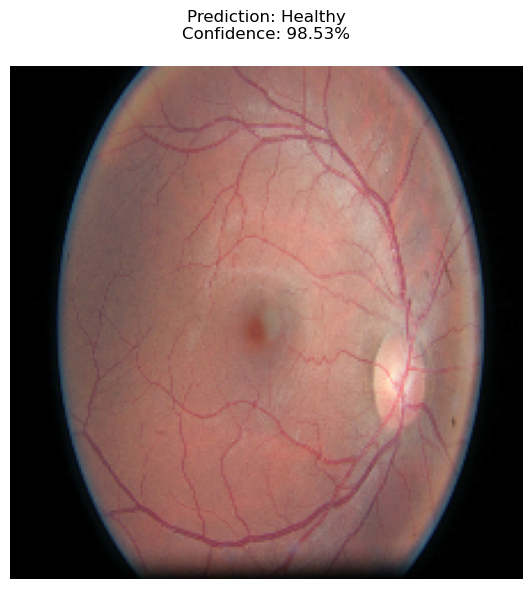

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


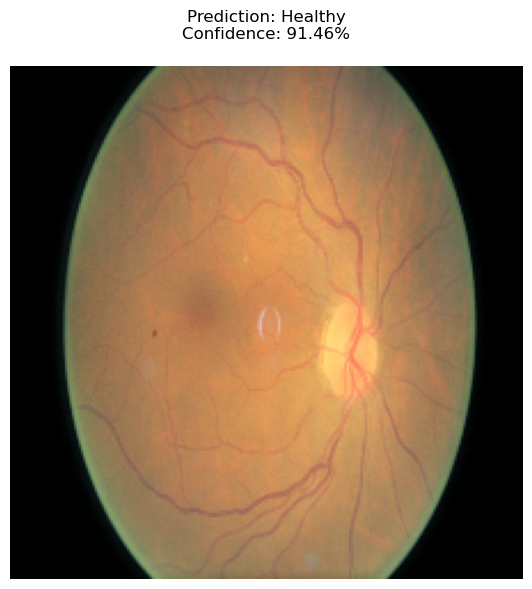

In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create main window first (must be before any messagebox)
root = tk.Tk()
root.title("Diabetic Retinopathy Detection")
root.geometry("500x650")
root.configure(bg="#f0f0f0")

# Safe import of TensorFlow
try:
    from tensorflow.keras.models import load_model
except ImportError as e:
    messagebox.showerror("Import Error", f"TensorFlow import failed: {str(e)}")
    root.quit()  # Close Tkinter app gracefully
    exit()

IMG_SIZE = 224
model = None  # Model will load later

def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("Could not read the image file")
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_normalized = img / 255.0
        return img, img_normalized
    except Exception as e:
        messagebox.showerror("Image Error", f"Error processing image: {str(e)}")
        return None, None

def upload_image():
    global model

    file_path = filedialog.askopenfilename(
        filetypes=[("Image Files", "*.jpg *.jpeg *.png"), ("All Files", "*.*")]
    )
    if not file_path:
        return

    if model is None:
        try:
            # Show temporary loading window
            loading = tk.Toplevel(root)
            loading.title("Loading Model")
            loading.geometry("300x100")
            loading_label = tk.Label(loading, text="Loading Model...\nPlease Wait", font=("Arial", 12))
            loading_label.pack(expand=True)
            loading.update()

            model = load_model('diabetic_retinopathy.keras')

            loading.destroy()  # Close loading window
        except Exception as e:
            loading.destroy()
            messagebox.showerror("Model Error", f"Failed to load model: {str(e)}")
            return

    original_img, processed_img = preprocess_image(file_path)
    if original_img is None:
        return

    try:
        img_array = np.expand_dims(processed_img, axis=0)
        pred = model.predict(img_array)
        pred_class = np.argmax(pred, axis=1)
        confidence = np.max(pred)

        class_names = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']

        result_label.config(text=f'Prediction: {class_names[pred_class[0]]}')
        confidence_label.config(text=f'Confidence: {confidence * 100:.2f}%')

        img = Image.fromarray(original_img)
        img = img.resize((300, 300))
        img = ImageTk.PhotoImage(img)
        img_label.config(image=img)
        img_label.image = img

        display_results(original_img, class_names[pred_class[0]], confidence)

    except Exception as e:
        messagebox.showerror("Prediction Error", f"An error occurred during prediction: {str(e)}")

def display_results(img_array, prediction, confidence):
    plt.figure(figsize=(8, 6))
    plt.imshow(img_array)
    plt.title(f"Prediction: {prediction}\nConfidence: {confidence*100:.2f}%", pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ===== GUI Elements =====

button_style = {
    "font": ("Arial", 12, "bold"),
    "bg": "#4CAF50",
    "fg": "white",
    "activebackground": "#45a049",
    "relief": tk.RAISED,
    "borderwidth": 3
}

result_style = {
    "font": ("Arial", 14, "bold"),
    "bg": "#f0f0f0"
}

# Upload Button
upload_btn = tk.Button(root, text="Upload Retina Image", command=upload_image, **button_style)
upload_btn.pack(pady=20)

# Image Display
img_frame = tk.Frame(root, bg="black", bd=2, relief=tk.SUNKEN)
img_frame.pack(pady=10)
img_label = tk.Label(img_frame, bg="black")
img_label.pack(padx=2, pady=2)

# Prediction Labels
result_label = tk.Label(root, text="Prediction: ", **result_style)
result_label.pack(pady=10)

confidence_label = tk.Label(root, text="Confidence: ", **result_style)
confidence_label.pack(pady=10)

# Footer
footer = tk.Label(root, text="Diabetic Retinopathy Detection System",
                  font=("Arial", 10), bg="#f0f0f0", fg="gray")
footer.pack(side=tk.BOTTOM, pady=10)

# Run the GUI
try:
    root.mainloop()
except Exception as e:
    messagebox.showerror("Fatal Error", f"Application crashed: {str(e)}")
    root.quit()


In [1]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
from PIL import Image, ImageTk
import numpy as np
import cv2
import matplotlib.pyplot as plt
from io import BytesIO

# Create main window
root = tk.Tk()
root.title("Deep Learning Diabetic Retinopathy Detection")
root.geometry("1000x800")  # Larger window
root.configure(bg="#f5f8fa")  # Light blue-gray background
root.resizable(True, True)

# Safe import of TensorFlow
try:
    from tensorflow.keras.models import load_model
except ImportError as e:
    messagebox.showerror("Import Error", f"TensorFlow import failed: {str(e)}")
    root.quit()
    exit()

IMG_SIZE = 224
model = None  # Model will load later

# Health recommendations
HEALTH_ADVICE = {
    'Healthy': {
        'diet': ["Leafy greens (spinach, kale)", "Fatty fish (salmon, tuna)",
                "Citrus fruits", "Nuts and seeds", "Whole grains"],
        'avoid': ["Excessive sugar", "Processed foods", "Trans fats"],
        'actions': ["Annual eye checkups", "Maintain blood sugar levels",
                   "Regular exercise", "Wear UV-protective sunglasses"]
    },
    'Mild DR': {
        'diet': ["Foods rich in lutein (kale, corn)", "Omega-3s (chia seeds, walnuts)",
                "Berries (blueberries, blackberries)", "Legumes"],
        'avoid': ["High sodium foods", "Sugary beverages", "Refined carbs"],
        'actions': ["3-6 month eye checkups", "Strict blood sugar control",
                   "Blood pressure management", "Quit smoking if applicable"]
    },
    'Moderate DR': {
        'diet': ["Vitamin C rich foods (bell peppers, broccoli)", "Zinc sources (oysters, beef)",
                "Antioxidant-rich foods (dark chocolate, artichokes)"],
        'avoid': ["Alcohol", "Fried foods", "Processed meats"],
        'actions': ["2-3 month specialist visits", "A1C below 7%",
                   "Cholesterol control", "Consider laser treatment"]
    },
    'Severe DR': {
        'diet': ["High-fiber foods (avocados, lentils)", "Vitamin E sources (almonds, sunflower seeds)",
                "Low-glycemic index foods"],
        'avoid': ["Simple carbohydrates", "High-fat dairy", "Excessive caffeine"],
        'actions': ["Immediate specialist consultation", "Possible anti-VEGF injections",
                   "Laser surgery options", "Strict diabetes management"]
    },
    'Proliferate DR': {
        'diet': ["Foods rich in vitamin K (parsley, prunes)", "Magnesium sources (pumpkin seeds, bananas)",
                "Hydrating foods (cucumber, watermelon)"],
        'avoid': ["Smoking completely", "High-mercury fish", "Artificial sweeteners"],
        'actions': ["Urgent medical intervention", "Vitrectomy may be needed",
                   "Regular monitoring for complications", "Comprehensive diabetes care team"]
    }
}

def preprocess_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("Could not read the image file")
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_normalized = img / 255.0
        return img, img_normalized
    except Exception as e:
        messagebox.showerror("Image Error", f"Error processing image: {str(e)}")
        return None, None

def upload_image():
    global model, current_image_path, current_diagnosis, current_confidence
    
    file_path = filedialog.askopenfilename(
        filetypes=[("Image Files", "*.jpg *.jpeg *.png"), ("All Files", "*.*")]
    )
    if not file_path:
        return
    
    current_image_path = file_path

    if model is None:
        try:
            loading = tk.Toplevel(root)
            loading.title("Loading Model")
            loading.geometry("300x100")
            loading.configure(bg="#f5f7fa")
            loading_label = tk.Label(
                loading, 
                text="Loading Deep Learning Model...\nPlease Wait", 
                font=("Arial", 12),
                bg="#f5f7fa",
                fg="#2c3e50"
            )
            loading_label.pack(expand=True)
            loading.update()

            model = load_model('diabetic_retinopathy.keras')

            loading.destroy()
        except Exception as e:
            loading.destroy()
            messagebox.showerror("Model Error", f"Failed to load model: {str(e)}")
            return

    original_img, processed_img = preprocess_image(file_path)
    if original_img is None:
        return

    try:
        img_array = np.expand_dims(processed_img, axis=0)
        pred = model.predict(img_array)
        pred_class = np.argmax(pred, axis=1)
        confidence = np.max(pred)

        class_names = ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']
        diagnosis = class_names[pred_class[0]]
        
        current_diagnosis = diagnosis
        current_confidence = confidence * 100

        result_label.config(text=f'Diagnosis: {diagnosis}', foreground=get_color_for_diagnosis(diagnosis))
        confidence_label.config(text=f'Confidence: {confidence * 100:.2f}%')

        # Update recommendations
        update_recommendations(diagnosis)

        # Display image
        img = Image.fromarray(original_img)
        img = img.resize((350, 350))  # Larger image display
        img = ImageTk.PhotoImage(img)
        img_label.config(image=img)
        img_label.image = img

    except Exception as e:
        messagebox.showerror("Prediction Error", f"An error occurred during prediction: {str(e)}")

def get_color_for_diagnosis(diagnosis):
    colors = {
        'Healthy': '#27ae60',  # Green
        'Mild DR': '#f39c12',  # Orange
        'Moderate DR': '#e67e22',  # Dark orange
        'Severe DR': '#e74c3c',  # Red
        'Proliferate DR': '#c0392b'  # Dark red
    }
    return colors.get(diagnosis, '#2c3e50')

def update_recommendations(diagnosis):
    advice = HEALTH_ADVICE.get(diagnosis, {})

    # Clear previous content
    for widget in diet_frame.winfo_children():
        widget.destroy()
    for widget in avoid_frame.winfo_children():
        widget.destroy()
    for widget in actions_frame.winfo_children():
        widget.destroy()

    # Add new content with better styling
    ttk.Label(diet_frame, text="Recommended Foods:", style='Subheader.TLabel').pack(anchor='w', pady=(0, 5))
    for item in advice.get('diet', []):
        ttk.Label(diet_frame, text=f"• {item}", style='Advice.TLabel').pack(anchor='w', padx=10)

    ttk.Label(avoid_frame, text="Avoid:", style='Subheader.TLabel').pack(anchor='w', pady=(0, 5))
    for item in advice.get('avoid', []):
        ttk.Label(avoid_frame, text=f"• {item}", style='Advice.TLabel').pack(anchor='w', padx=10)

    ttk.Label(actions_frame, text="Recommended Actions:", style='Subheader.TLabel').pack(anchor='w', pady=(0, 5))
    for item in advice.get('actions', []):
        ttk.Label(actions_frame, text=f"• {item}", style='Advice.TLabel').pack(anchor='w', padx=10)

# ===== GUI Elements =====

# Custom styles with modern look
style = ttk.Style()
style.theme_use('clam')

# Configure styles
style.configure('TFrame', background='#f5f8fa')
style.configure('TLabel', background='#f5f8fa', font=('Arial', 10), foreground='#2c3e50')
style.configure('Header.TLabel', font=('Arial', 18, 'bold'), foreground='#3498db')
style.configure('Result.TLabel', font=('Arial', 16, 'bold'))
style.configure('Confidence.TLabel', font=('Arial', 14))
style.configure('Subheader.TLabel', font=('Arial', 12, 'bold'), foreground='#2980b9')
style.configure('Advice.TLabel', font=('Arial', 11), foreground='#34495e')
style.configure('Upload.TButton',
                font=('Arial', 12, 'bold'),
                foreground='white',
                background='#3498db',
                borderwidth=0,
                relief='flat',
                padding=12,
                focusthickness=0,
                focuscolor='none')
style.configure('TLabelframe', background='#f5f8fa', bordercolor='#bdc3c7', relief='solid')
style.configure('TLabelframe.Label', background='#f5f8fa', foreground='#2980b9', font=('Arial', 12, 'bold'))

style.map('Upload.TButton',
          background=[('active', '#2980b9'), ('pressed', '#1a5276')],
          foreground=[('active', 'white')])

# Header Frame with gradient effect
header_frame = tk.Frame(root, bg='#3498db', height=80)
header_frame.pack(fill='x', pady=(0, 15))

header_label = tk.Label(
    header_frame,
    text="Deep Learning Diabetic Retinopathy Detection",
    font=('Arial', 20, 'bold'),
    bg='#3498db',
    fg='white'
)
header_label.pack(expand=True)

# Upload Section with modern card design
upload_container = tk.Frame(root, bg='#ecf0f1', bd=0, highlightthickness=0)
upload_container.pack(pady=10, padx=20, fill='x')

upload_frame = tk.Frame(upload_container, bg='white', bd=1, relief='solid', highlightbackground='#bdc3c7')
upload_frame.pack(fill='both', expand=True, padx=5, pady=5)

upload_btn = ttk.Button(
    upload_frame,
    text="Upload Retina Image",
    command=upload_image,
    style='Upload.TButton'
)
upload_btn.pack(pady=15, ipadx=30)

# Image and Results Frame with card design
results_container = tk.Frame(root, bg='#ecf0f1', bd=0, highlightthickness=0)
results_container.pack(fill='both', expand=True, padx=20, pady=10)

# Image Display Card
image_card = tk.Frame(results_container, bg='white', bd=1, relief='solid', highlightbackground='#bdc3c7')
image_card.pack(side='left', fill='both', expand=True, padx=5, pady=5)

image_frame = ttk.LabelFrame(
    image_card,
    text="Retina Scan",
    style='TLabelframe',
    padding=15
)
image_frame.pack(fill='both', expand=True, padx=5, pady=5)

img_label = tk.Label(image_frame, bg="white", bd=0)
img_label.pack(fill='both', expand=True)

# Results Display Card
results_card = tk.Frame(results_container, bg='white', bd=1, relief='solid', highlightbackground='#bdc3c7')
results_card.pack(side='left', fill='both', expand=True, padx=5, pady=5)

results_frame = ttk.LabelFrame(
    results_card,
    text="Analysis Results",
    style='TLabelframe',
    padding=20
)
results_frame.pack(fill='both', expand=True, padx=5, pady=5)

result_label = ttk.Label(
    results_frame,
    text="Diagnosis: ",
    style='Result.TLabel'
)
result_label.pack(anchor='w', pady=(0, 10))

confidence_label = ttk.Label(
    results_frame,
    text="Confidence: ",
    style='Confidence.TLabel'
)
confidence_label.pack(anchor='w', pady=(0, 15))

# Recommendations Section with card design
rec_container = tk.Frame(root, bg='#ecf0f1', bd=0, highlightthickness=0)
rec_container.pack(fill='both', expand=True, padx=20, pady=(0, 20))

rec_card = tk.Frame(rec_container, bg='white', bd=1, relief='solid', highlightbackground='#bdc3c7')
rec_card.pack(fill='both', expand=True, padx=5, pady=5)

recommendations_frame = ttk.LabelFrame(
    rec_card,
    text="Health Recommendations",
    style='TLabelframe',
    padding=15
)
recommendations_frame.pack(fill='both', expand=True, padx=5, pady=5)

# Create a canvas and scrollbar for recommendations
rec_canvas = tk.Canvas(recommendations_frame, bg='white', highlightthickness=0)
scrollbar = ttk.Scrollbar(recommendations_frame, orient="vertical", command=rec_canvas.yview)
scrollable_frame = ttk.Frame(rec_canvas, style='TFrame')

scrollable_frame.bind(
    "<Configure>",
    lambda e: rec_canvas.configure(
        scrollregion=rec_canvas.bbox("all")
    )
)

rec_canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
rec_canvas.configure(yscrollcommand=scrollbar.set)

rec_canvas.pack(side="left", fill="both", expand=True)
scrollbar.pack(side="right", fill="y")

# Three columns for recommendations inside scrollable frame
diet_frame = ttk.Frame(scrollable_frame, style='TFrame')
diet_frame.pack(side='left', fill='both', expand=True, padx=15)

avoid_frame = ttk.Frame(scrollable_frame, style='TFrame')
avoid_frame.pack(side='left', fill='both', expand=True, padx=15)

actions_frame = ttk.Frame(scrollable_frame, style='TFrame')
actions_frame.pack(side='left', fill='both', expand=True, padx=15)

# Run the GUI
try:
    root.mainloop()
except Exception as e:
    messagebox.showerror("Fatal Error", f"Application crashed: {str(e)}")
    root.quit()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
